# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

There are many features embedded in job descriptions. Is there any association betweeen the job description and salary? If so, what are the important features? 

In [2]:
#import your libraries
import pandas as pd
import sklearn as sk
#etc

#your info here
__author__ = "Linchen Deng"
__email__ = "linchen_deng@brown.edu"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [4]:
#load the data into a Pandas dataframe
train_X = pd.read_csv("data/train_features.csv")
train_y = pd.read_csv("data/train_salaries.csv")
test_X = pd.read_csv("data/test_features.csv")

### ---- 3 Clean the data ----

In [15]:
# Take a look at the training data
train_X.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [13]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
print(train_X.shape)
print(train_X.info())

(1000000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB
None


In [14]:
print(train_y.shape)
print(train_y.info())

(1000000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB
None


In [10]:
# There is no NAs in the training data 
train_X.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [12]:
# There is no duplicated row in the training data
train_X[train_X.duplicated()]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis


In [19]:
# Check non-positive salaries
wrong_salary_rows = train_y["salary"]<=0
train_y[wrong_salary_rows]

,jobId,salary
30559,JOB1362684438246,0
495984,JOB1362684903671,0
652076,JOB1362685059763,0
816129,JOB1362685223816,0
828156,JOB1362685235843,0


In [22]:
# remove rows with zero salaries in the training data
train_X.drop(train_X[wrong_salary_rows].index, inplace=True)
train_y.drop(train_y[wrong_salary_rows].index, inplace=True)

### ---- 4 Explore the data (EDA) ----

In [23]:
#summarize numeric features
train_X.describe()

,yearsExperience,milesFromMetropolis
count,999995.000000,999995.000000
mean,11.992407,49.529381
std,7.212390,28.877721
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


AxesSubplot(0.125,0.125;0.775x0.755)
HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64
NONE           532353
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58594
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57800
Name: major, dtype: int64
WEB          143205
AUTO         142941
FINANCE      142866
EDUCATION    142819
OIL          142770
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64


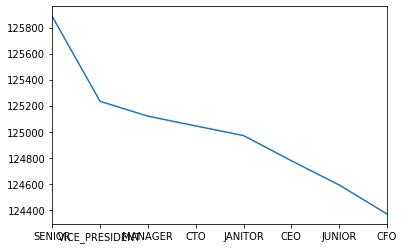

In [91]:
# Counts of levels in each categorical feature 
print(train_X.jobType.value_counts().plot())
print(train_X.degree.value_counts())
print(train_X.major.value_counts())
print(train_X.industry.value_counts())

In [24]:
#summarize the target variable
train_y.describe()

,salary
count,999995.000000
mean,116.062398
std,38.717163
min,17.000000
25%,88.000000
50%,114.000000
75%,141.000000
max,301.000000


In [31]:
# combine features and salaries for visualizations
train_combined = pd.merge(left=train_X,right=train_y, left_on='jobId', right_on='jobId')

In [35]:
#look for correlation between each feature and the target
train_combined.dtypes

jobId                  object
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object

In [65]:
def barplot_categorical(data, variable_x):
    ordered_category = data.groupby(variable_x).salary.mean().sort_values(ascending=False).index
    ax = sns.barplot(x="salary",y=variable_x,data=data, order=ordered_category)

#### Job Type and Salary
On average, CEO makes more salary than CTO and CFO; Manager makes more than senior, which is more than junior; Janitor makes the least.

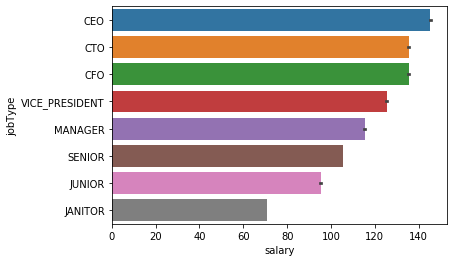

In [66]:
import seaborn as sns
barplot_categorical(train_combined, "jobType")

#### Degree and Salary
On average, phD > Masters > Bachelors > High School > None(categorized as below high school)
The salary gap between a high school and a Bachelor's degree is 4 times higher than the difference either between Bachelor's and Master's or Master's and phD.  

In [87]:
train_combined.groupby("degree").salary.mean()

degree
BACHELORS      125.454663
DOCTORAL       135.490979
HIGH_SCHOOL    101.921085
MASTERS        130.505647
NONE            98.176882
Name: salary, dtype: float64

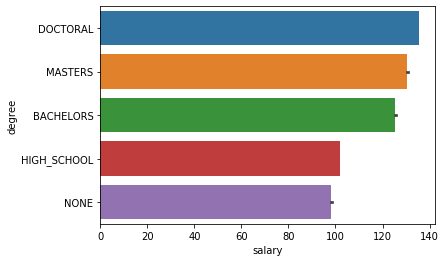

In [69]:
barplot_categorical(train_combined, "degree")

#### major and salary
Engineering, business, math, computer science (Practical and Generally Appliable majors) have higher salaries than physics, chemistry, biology, literature (Basic sciences and Art majors). 

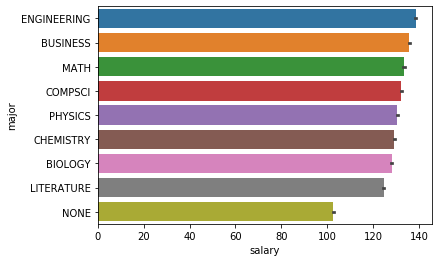

In [71]:
barplot_categorical(train_combined, "major")

#### industry and salary
Oil and finance industry have higher salary than web, health, auto industry, higher than service and education industry.

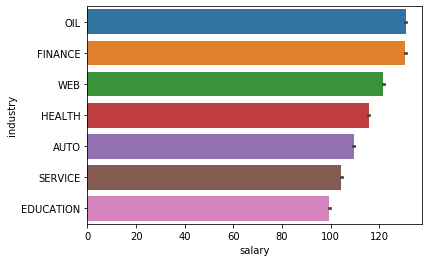

In [72]:
barplot_categorical(train_combined, "industry")

#### Years experience and salary
On average, more years of experience is correlated with higher salary.

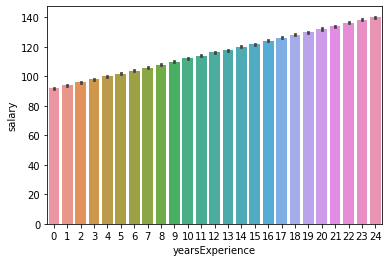

In [75]:
sns.barplot(x="yearsExperience",y="salary",data=train_combined)

#### Miles from metropolis and salary
The further the job from the metropolis, the lower the salary.

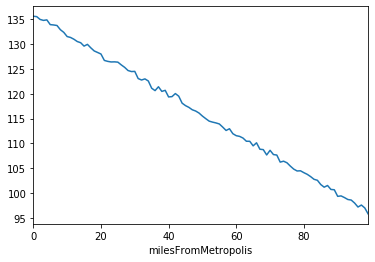

In [85]:
train_combined.groupby("milesFromMetropolis").salary.mean().plot()

### look for correlation between features

### ---- 5 Establish a baseline ----

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data